# 4. Dueling Double Deep Q-Learning for Navigation

In this final notebook I will give a forth solution to the [Unity ML Banana-Collector environment](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#banana-collector) using [Dueling Double Deep Q-Learning](https://arxiv.org/pdf/1509.06461.pdf). See the [README](https://github.com/bobflagg/Deep-Q-Learning-for-Navigation/blob/master/README.md) for instructions on how to setup your environment to run the code here.  

This solution simply uses the double deep Q-learning algorithm with a dueling Q-network.

I'll first need to define the dueling Q-network class.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DuelingQNetwork(nn.Module):
    
    def __init__(
        self, 
        state_size, 
        action_size, 
        seed=0, 
        fc1_units=64, 
        fc2_units=64,
        adv_fc_units=32, 
        val_fc_units=32, 
    ):

        super(DuelingQNetwork, self).__init__()
        
        self.state_size = state_size
        self.action_size = action_size
        
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)

        self.adv_fc1 = nn.Linear(fc2_units, adv_fc_units)
        self.adv_fc2 = nn.Linear(adv_fc_units, action_size)

        self.val_fc1 = nn.Linear(fc2_units, val_fc_units)
        self.val_fc2 = nn.Linear(val_fc_units, 1)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        
        adv = F.relu(self.adv_fc1(x))
        adv = self.adv_fc2(adv)

        val = F.relu(self.val_fc1(x))
        val = self.val_fc2(val)

        return val + adv - adv.mean()

Next I'll need an agent that uses dueling Q-networks and learns according to the double Q-learning algorithm.

In [2]:
from dqn_agent import TAU

from dqn_agent import Agent, BUFFER_SIZE, BATCH_SIZE, LR, ReplayBuffer
import random
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class DuelingDoubleQAgent(Agent):
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = DuelingQNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = DuelingQNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # Get predicted actions for next states from local model
        next_actions = self.qnetwork_local(next_states).detach().argmax(1).unsqueeze(1)
        Q_targets_next = self.qnetwork_target(next_states).gather(1, next_actions)

        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)


        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

Now I'm ready to train.

In [3]:
from trainer import train
from unityagents import UnityEnvironment

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Episode 100	Average Score: 0.59
Episode 200	Average Score: 3.39
Episode 300	Average Score: 6.72
Episode 400	Average Score: 9.95
Episode 500	Average Score: 12.54
Episode 511	Average Score: 13.08
Environment solved in 411 episodes!	Average Score: 13.08


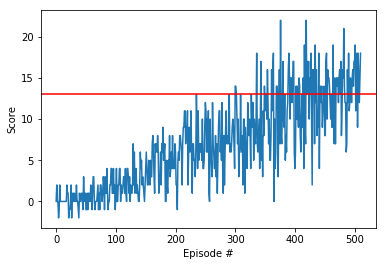

CPU times: user 4min 39s, sys: 24.3 s, total: 5min 4s
Wall time: 9min 36s


In [4]:
%%time
import matplotlib.pyplot as plt
%matplotlib inline  

env = UnityEnvironment(file_name="./data/Banana.app")
agent = DuelingDoubleQAgent(state_size=37, action_size=4, seed=0)
scores = train(env, agent)

So the [Unity ML Banana-Collector environment](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#banana-collector)
was solved in 411 episodes. That's a little disappointing but before deciding which of the 4 methods I've considered is best, I would need to sytematically tune the hyper-parameters for each one.  Until then, the current champion is dueling deep Q-learning.

I'll save the weights of the local network of this successful agent to the file dueling-double-dqn-model-weights.pth.

In [5]:
torch.save(agent.qnetwork_local.state_dict(), 'dueling-double-dqn-model-weights.pth')